# Creating a Price Forecast for 5 days Ahead

Within a company, there are several risk factors to be considered and managed. For instance, price changes where the manager has to decide the best moment to sell; product demand forecast to improve the inventory management. Another important factor to evaluate is forecasts about recurrent expenses since expressive values can impact the company's working capital.

Usually, the forecasts on prices, demand, expenses, etc are created taking into account manager's domain knowledge as well as essential information on the specific subject that influences decision making.

When predictive models are used, the data is separated between training and test set, the coefficients are generated in the training data and they are usually tested step by step in the test set. Thus, only one period is forecasted, then it updates with real values and so on until the end of the test set.

In this notebook an [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) model will be created, then the coefficients obtained in the training set will be tested in a slightly different way, 5 consecutive days will be forecasted, then it will be updated with real data (5 days in a row) and again new forecasts will be created for 5 periods until the test data is over.

This kind of approach is interesting for those who want to create forecast models with several periods ahead, since it can easily be used to compare the forecasted extrapolations with real data, thus, verify what are the main characteristics of the model and what are the points that can be improved.

The objective of the model is to predict the daily price of the next 5 days of the 50kgs bag of Crystal Sugar
informed by Esalq, the data can be downloaded **[here](https://www.cepea.esalq.usp.br/br/indicador/acucar.aspx) (please, download the data from the Brazilian site, the English version doesn't have the prices in Brazilian Reais (BRL).**

From now on we will use the following steps, extracted from my post **[Basic Principles to Create a Time Series Forecast](https://towardsdatascience.com/basic-principles-to-create-a-time-series-forecast-6ae002d177a4?source=friends_link&sk=15a1d49ec9542c21f90eebe660b1455c)**, if you do not have much idea about the basis for creating these forecasts, I recommend you to read it:

 * Split the series into training and test set,
 * Transform the series into stationary,
 * Search for correlated lags,
 * Create the model,
 * Plot the comparative graph on the training set,
 * Evaluate the model and the error in the test set,
 * Suggest possible improvements to the model.

First of all let's import the essential libraries to work with time series:

In [1]:
#importing essential libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.animation import FuncAnimation
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
sns.set_context("paper")
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading the data
df = pd.read_excel('EsalqCristal.xls')
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df.sort_values('Data', inplace=True)
df.columns = ['Date','Crystal']
df.set_index('Date', inplace=True)
df.head()

,Crystal
Date,
2003-05-20,29.65
2003-05-21,29.26
2003-05-22,28.81
2003-05-23,28.35
2003-05-26,27.83


# Creating Training and Testing set

We have a price history of approximately 16 years, we will reserve the last **250 working days** (approx 1 year) to test the model, there will be 50 comparatives of 5 days each, between the forecasts and current values. All previous data will be used to train the model:

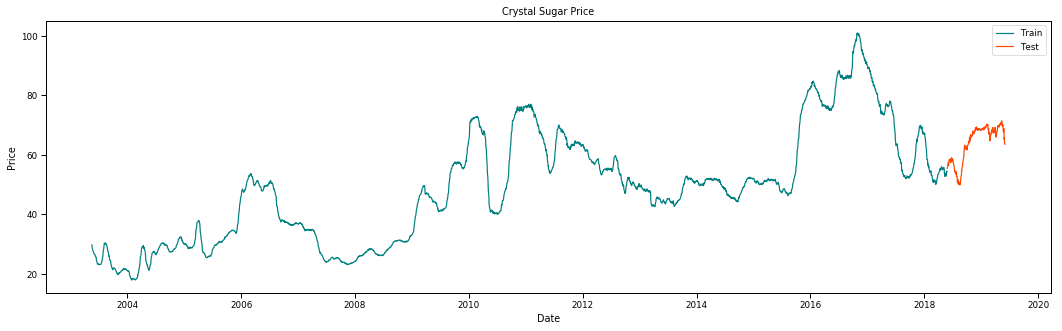

In [3]:
days = 250
train = df.iloc[:-days,0:1].copy()
test = df.iloc[-days:,0:1].copy()
plt.figure(figsize=(18,5))
plt.title('Crystal Sugar Price')
plt.plot(train['Crystal'], color='teal')
plt.plot(test['Crystal'], color='orangered')
plt.legend(['Train','Test'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Stationarity test and verifying correlated lags

In order to create a time series forecast it is necessary that the series is stationary, that is, it has the following relatively constant conditions: mean, variance and autocorrelation.

Below I will use the function to plot the series, its distribution, [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation), partial autocorrelation and to check the stationarity we will use the [Dickey Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) statistical test:

In [4]:
#creating a function to plot the graph and show the test result:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize, color='teal')
    ax1.set_title('Crystal Sugar Price')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2, color='teal');
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3, method='ols', color='teal');
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4, color='teal')
    ax4.set_title('Price Distribution')

    plt.tight_layout()
    
    print('Dickey-Fuller test results:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Statistical Test','P-Value','Used Lags','Observations Number'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Values (%s)"%key] = value.round(4)
        
    print(adftest)

To verify if the values on the training data are stationary, we will use the P value of 5% as a basis, if the P-value of this test is less than 5% we may consider the series as stationary:

Dickey-Fuller test results:
Statistical Test           -2.6288
P-Value                     0.0872
Used Lags                   7.0000
Observations Number      3714.0000
Critical Values (1%)       -3.4321
Critical Values (5%)       -2.8623
Critical Values (10%)      -2.5672
dtype: float64


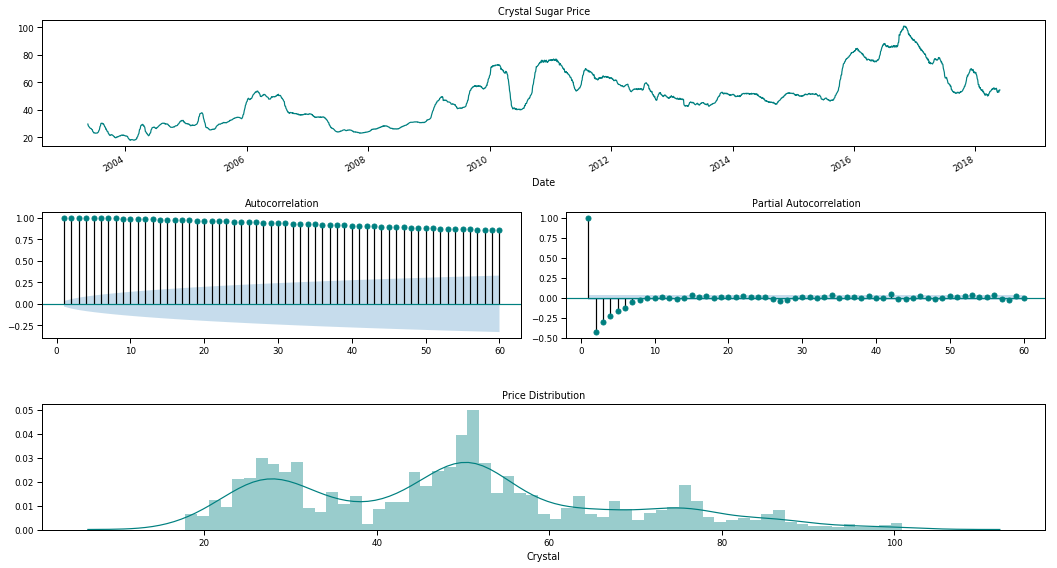

In [5]:
check_stationarity(train['Crystal'], lags_plots=60)

Analyzing the graphs, it's noticed that the price series has a slight upward tendency, the distribution graph shows that the data doesn't follow a Gaussian normality, and the characteristics of the **autocorrelation** show significant correlations in all lags, this is a sign of a series with some trend and finally the statistical values informs that the P value was 8.7%.

Thus, this series does not meet the criteria established to be considered stationary.

I will make the first differentiation to cancel the trend and stay only the day-to-day movements:

Dickey-Fuller test results:
Statistical Test          -11.3823
P-Value                     0.0000
Used Lags                   5.0000
Observations Number      3715.0000
Critical Values (1%)       -3.4321
Critical Values (5%)       -2.8623
Critical Values (10%)      -2.5672
dtype: float64


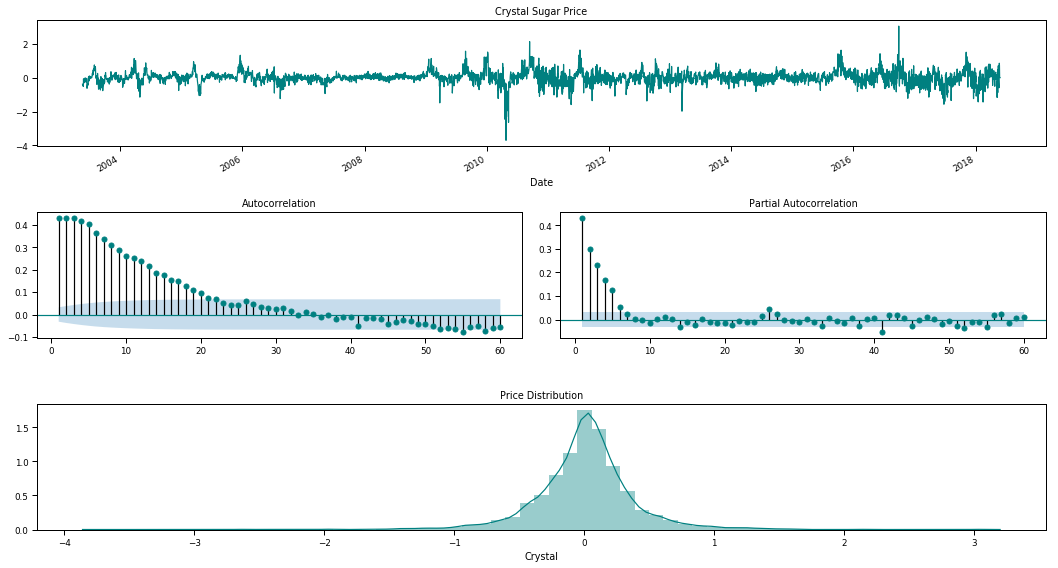

In [6]:
check_stationarity(train['Crystal'].diff().dropna(), lags_plots=60)

The Dickey Fuller test returned a **P value** of zero, which means that the series became stationary, to complement, it's noted in the graph that the trend has disappeared and prices are relatively stable.

In the autocorrelation graph the values gradually decrease, different from the graph without differentiation.

The partial autocorrelation falls more abruptly, showing that the first three values have significant impact on the current values, apparently there is no significant seasonal correlation to be considered in the predictions.

In this way, we may consider an auto regressive model with the first 3 lags in a differenced series, so we will use this following terminology for the model: **ARIMA (3, 1.0)**

# Creating the Model

Initially the model will be created based on the training data, thus, the coefficients for the 3 auto correlated lags will be generated and will serve to test the extrapolation of 5 consecutive days in the test set.

There are several ways to make extrapolations for the future, the main ones are:

  * Create a model for each specific day to be forecasted and add everything later in a final model,
  * Recursive, forecasting the first day and use this value as a basis to forecast the next day.
 
We will use the last model in this example, in this case we will forecast the next 5 days, compare with real data, add the latter to the model in order to make a new extrapolation, later we will calculate the error of the model and analyze relevant facts of the forecast.

In [7]:
# Training the model
model = ARIMA(train, order=(3,1,0)).fit()
train_pred = model.predict()

Let us now compare the current data with those forecasted, as the forecast was made on the model with differentiation (as can be seen below) the first real value will be added and summed cumulatively to take back the base price to BRL/bags.

In [8]:
# Prediction base with one diferencing
train_pred[:5]

Date
2003-05-21    0.006286
2003-05-22   -0.164735
2003-05-23   -0.250335
2003-05-26   -0.298730
2003-05-27   -0.328869
dtype: float64

In [9]:
# Returning the price to BRL/bags
train_pred[0] += train.iloc[0,0]
train_pred = np.cumsum(train_pred)
train_pred.head()

Date
2003-05-21    29.656286
2003-05-22    29.491551
2003-05-23    29.241216
2003-05-26    28.942486
2003-05-27    28.613616
dtype: float64

Now the predicted values will be added in the training DataFrame to plot the graph with the two series:

In [10]:
train['Crystal Pred'] = train_pred
train.dropna(inplace=True)
train.head()

,Crystal,Crystal Pred
Date,,
2003-05-21,29.26,29.656286
2003-05-22,28.81,29.491551
2003-05-23,28.35,29.241216
2003-05-26,27.83,28.942486
2003-05-27,27.76,28.613616


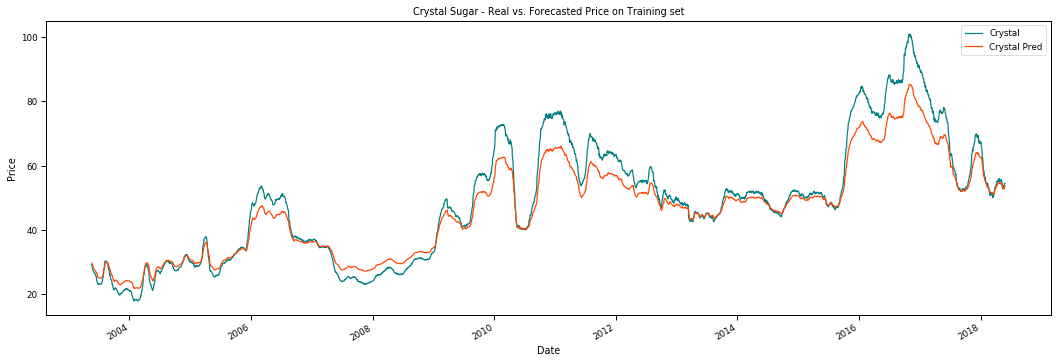

In [11]:
# Plotting the graph
train.plot(figsize=(18,6), 
            title='Crystal Sugar - Real vs. Forecasted Price on Training set',
           color=['Teal','orangered'])
plt.ylabel('Price')
plt.show()

In the training base the model manages to capture the main moments of the market. Only when there are greater variations that the forecast can not capture the movement, now let's analyze the error of the model:

In [12]:
# Measuring Training Error by Root Mean Squared Error
from sklearn.metrics import mean_squared_error
error = sqrt(mean_squared_error(train['Crystal'], train['Crystal Pred']))
print(f'The RMSE was BRL {round(error,4)}/bag')

The RMSE was BRL 4.9671/bag


# Getting the Coefficients

After training the model, we can obtain the multiplication coefficients of the differenced values and also the constant of the model, these values will serve as a basis for extrapolating the forecasts for the next 5 days.

In [13]:
# Taking the constant and the coefficients of the lags to use in the test base:
const, l1, l2, l3 = model.params

print(f'Constant value {round(const, 4)}')
print(f'Cofficients of Lag 1: {round(l1,4)}, Lag 2: {round(l2,4)} and Lag 3: {round(l3,4)}')

Constant value 0.0063
Cofficients of Lag 1: 0.2332, Lag 2: 0.2297 and Lag 3: 0.2309


The next step is to create a forecasting function, I will use all bases with differentiation and I'll create the forecast for 5 periods ahead, then I'll update the test set with current data (5 consecutive days) and so on until the end of the test data.

In [14]:
def predict_n_steps(train, test, steps):
    
    # # Adding differenced series to create a forecast
    diff_train = train.diff().dropna().values
    hist = [x for x in diff_train]

    diff_test = test.diff().dropna().values
    diff_test = [x for x in diff_test]

    # Adding the first differenced value in the test set that was between the training and test set
    first_diff = train[-1] - test[0]
    diff_test.insert(0, first_diff)
    
    pred = []

    for i in range(0,len(test), steps):
        for j in range(steps):
    
            yhat = const + (l1 * hist[-1]) + (l2 * hist[-2]) + (l3 * hist[-3])
            pred.append(yhat)
            # using the current forecast as the basis for new forecasts
            hist.append(yhat)
        obs = diff_test[i:i+steps]
        hist = list(np.append(hist,obs))
    return pred

In [15]:
# Testing the function
steps = 5
pred = predict_n_steps(train['Crystal'], test['Crystal'], steps=steps)
print('Predictions before reverting the diferentiation: ')
print(pred[:5])

Predictions before reverting the diferentiation: 
[0.17477782558127006, 0.053966184856814814, 0.059013042826703804, 0.07279059649919215, 0.04927191191727104]


The same way we created the function to predict prices with 5 days of extrapolation, we will create the function below to transform the expected prices to a comparable basis with the current prices of the test set.

In [16]:
def inverse_diff(train, test, prediction, steps):
    '''
    Using the last day of the training base, after that, I use the last 4 forecasted values as basis, recurrently until
    the end of the series
    '''
    train = [x for x in train]
    test = [x for x in test]
    inverted_pred = []
    
    for i in range(0,len(test), steps): 
        invert = train[-1] + prediction[i]
        inverted_pred.append(invert)
        
        for j in range(steps-1):
            invert += prediction[i+j+1]
            inverted_pred.append(invert)
        train = np.append(train, test[i:i+steps])
    return inverted_pred

In [17]:
# Adding the forecast in the test set to compare later
test['Crystal Pred'] = inverse_diff(train['Crystal'],
                                    test['Crystal'],
                                    pred, steps=steps)

# Plotting the Comparative

To conclude, the function below will separate each forecast over the 5-day periods and compare with the test base:

In [18]:
def plot_comparative(orig, pred, steps, title='', figsize=(18,8)):
    plt.figure(figsize=figsize)
    
    orig = np.array(orig)
    pred = np.array(pred)
    plt.plot(orig, color='teal')
    
    for i in range(0,len(orig), steps):
        x_axis = [x for x in range(i,i+steps)]
        plt.plot(x_axis, pred[i:i+steps], color='orangered')
    
    plt.title(title, fontsize=12)
    plt.ylabel('Prices')
    plt.legend(('Original', 'Prediction'))
    plt.show()

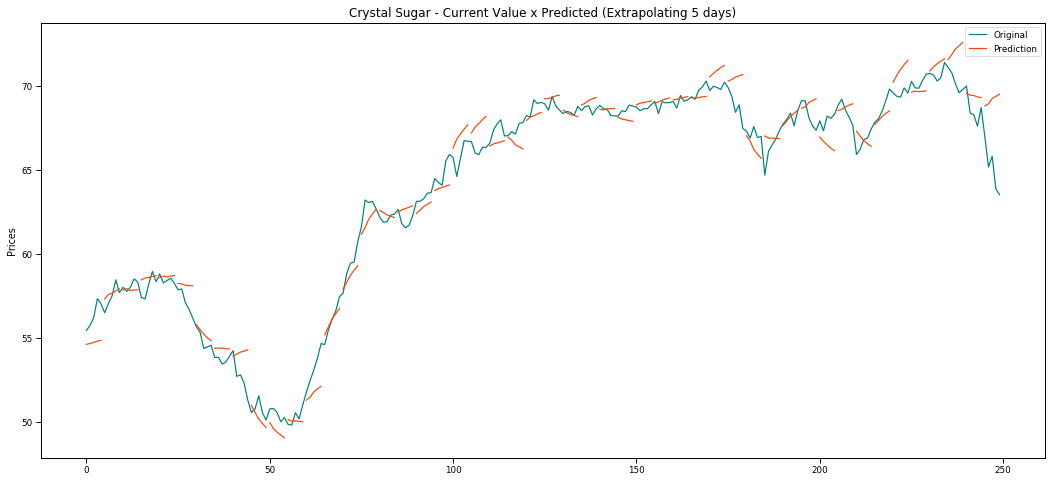

In [19]:
plot_comparative(test['Crystal'], test['Crystal Pred'], steps=steps, 
                   title='Crystal Sugar - Current Value x Predicted (Extrapolating 5 days)')

In [20]:
test_error = sqrt(mean_squared_error(test['Crystal'], test['Crystal Pred']))
print(f'The RMSE on the test set was BRL {round(test_error,4)}/bag')

The RMSE on the test set was BRL 1.1522/bag


Evaluating the graph above, it is noted that the main characteristic of this kind of forecast is that it follows the most recent trend being negotiated, but there is still room for improvement, the model is not able to predict possible changes in trends.

Next, i'll be analyzing the error (predicted - real) in a different way to obtain information to improve the model.

# Analyzing the Error

To analyze the error I will create a function similar to the previous ones, the 5 steps average error will be analyzed separatelly, the tendency is usually that the error, in this case the RMSE, increases according to the extrapolated periods due to uncertainties:

In [21]:
def n_steps_error(orig, pred, steps, plot=True):
    # Calculating the RMSE on each step
    error = ((np.array(orig) - np.array(pred))**2)**(1/2)
    
    # Changing the shape to become: (examples, steps)
    error = error.reshape(int(len(error)/steps), steps)
    
    # Calculating the mean error on each step
    mean = error.mean(axis=0)
    
    # Plotting the error graph
    if plot:
        index = np.arange(0,steps)
        plt.figure(figsize=(12,4))
        plt.plot(mean, 'o-', color='teal', markersize=8)
        plt.title('RMSE for each step', fontsize=15)
        plt.xlabel('Steps', fontsize=15)
        plt.ylabel('Error', fontsize=15)
        for x, y in zip(index, mean):
            label = "{:.4f}".format(y)
            plt.annotate(label, (x, y), xytext=(x-0.1, y+.075), fontsize=12)
        plt.xticks(np.arange(steps), [x for x in range(1,steps+1)])
        plt.yticks([x for x in np.linspace(min(mean)-0.2, max(mean)+0.2, 10)])
        plt.grid(axis='y')
        plt.show()
    print(f'The RMSE for each step is: \n{mean}')

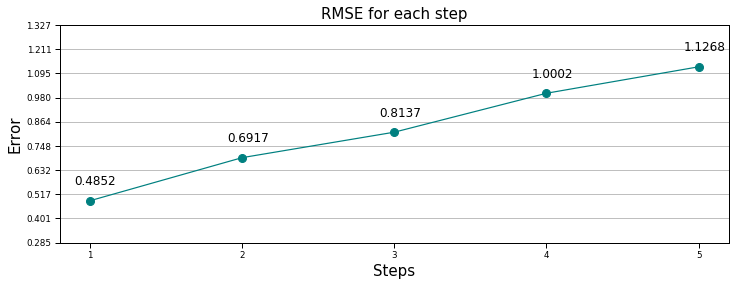

The RMSE for each step is: 
[0.48524694 0.69167403 0.81373203 1.00020175 1.12683736]


In [22]:
error_steps = n_steps_error(test['Crystal'], test['Crystal Pred'], steps)
error_steps

As predicted, at each step the RMSE increases, this is due to the uncertainties regarding the future and also that the forecasts starting from the second step are made based on forecasted values and not real ones.

Below are some ideas that can help to improve the accuracy of the model:

  * Create an ensemble of various models (LSTM, Garch, MLP, TBATS, etc.) and make an average price,
  * Some models may have better predictions for some specific step, you can use the model that has the smallest error in each step, so that it can have a final model with different models per step and with minor errors,
  * Analyze different error metrics such as MAE, Bias, etc. to verify specific characteristics of each kind of metric,
  * Test possible seasonal lags to predict recurring movements,
  * Resample the data do weekly basis,
  * Add correlated external data,
  * Normalize the data,
  * Transformation with logarithms or using the Box-Cox transformation.
 
Simple models or even Artificial Intelligence techniques to create forecasts with several periods ahead are undoubtedly a tool of extreme importance.

Faced with an increasingly competitive market, creating a model with proven accuracy can be a differential for the company, because it can capture possible market movements that may be essential in the decision making of the administrator.

Models like this can be used as an important tool to create cash flows, manage production and inventory, as well as identify market opportunities.

I hope you liked this post, any questions or information I'm available to answer any questions, also see the link to connect with me on my [LinkedIn](https://www.linkedin.com/in/leandro-rabelo-08722824/).

# Extra Feature:

Below I created an animation, showing the dynamics of the forecasts with the updates of real prices later:

<IPython.core.display.Javascript object>


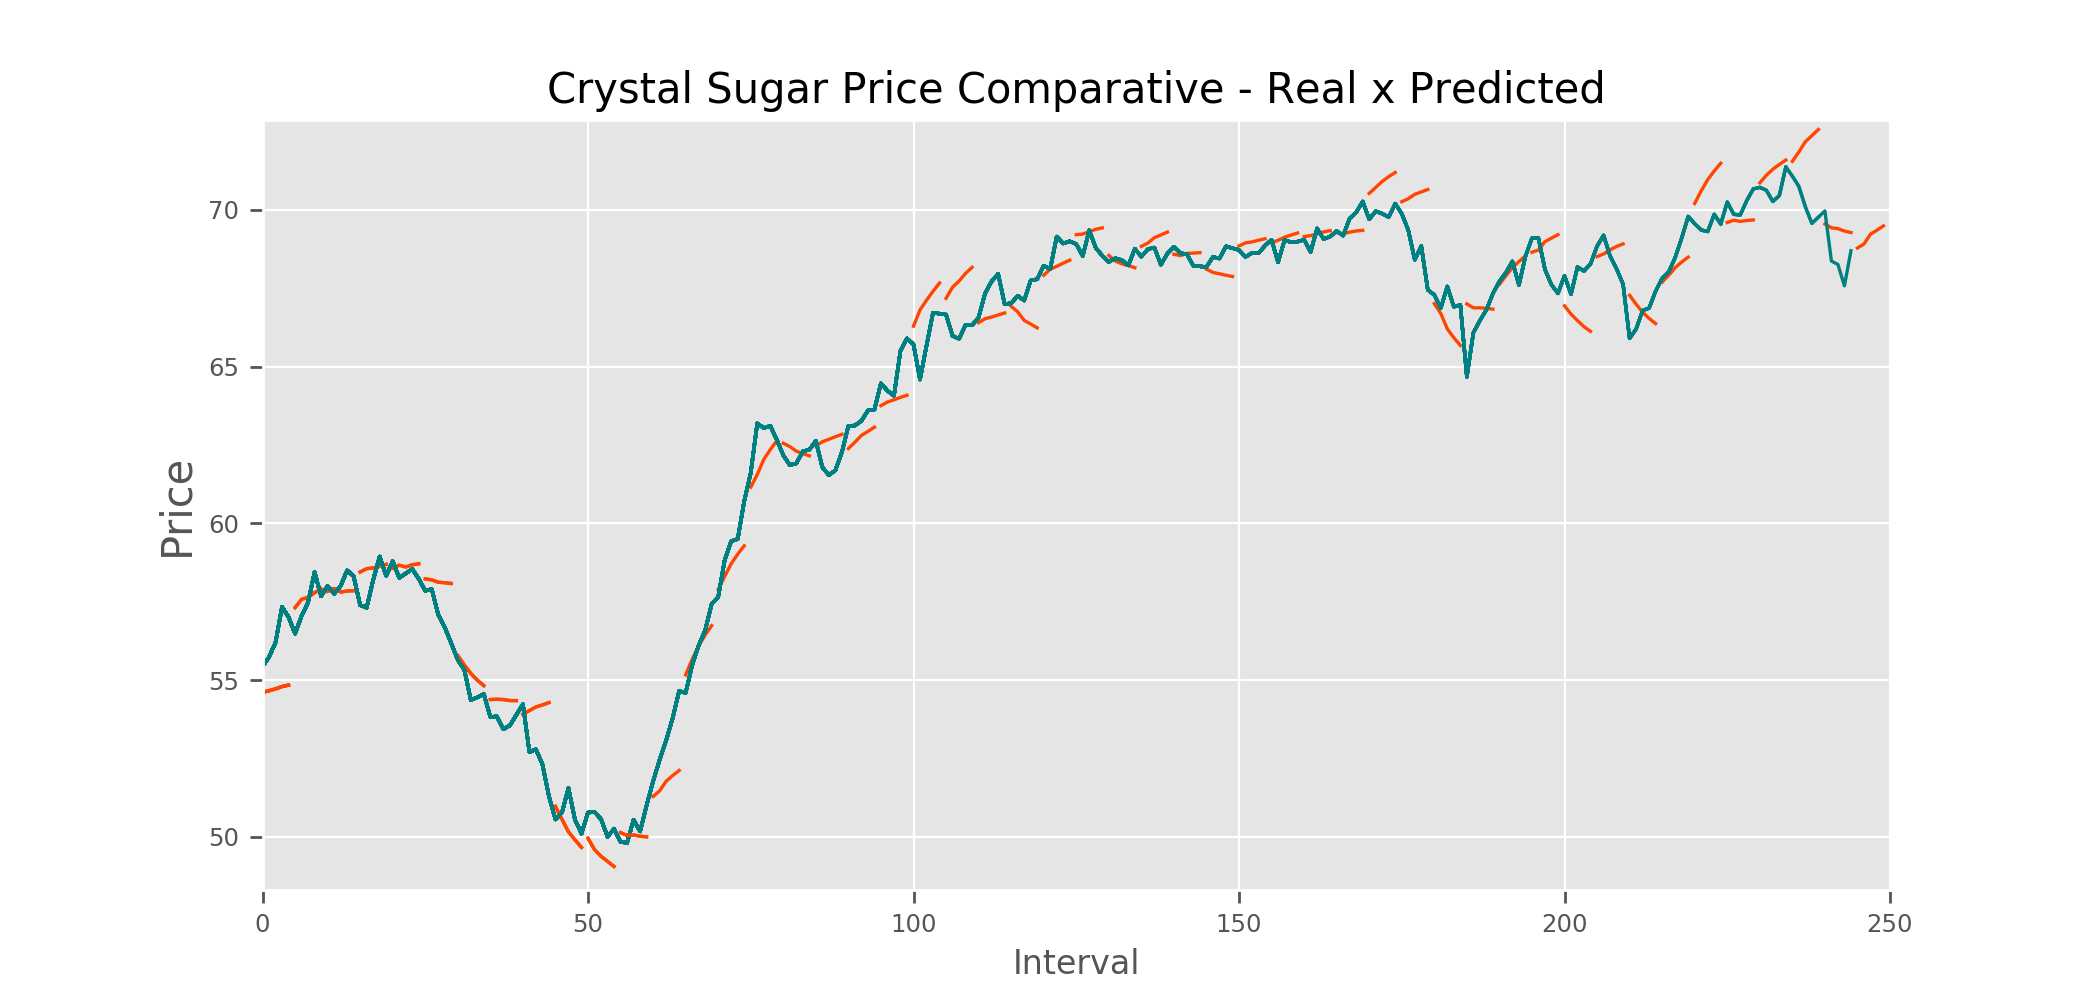

In [26]:
%matplotlib notebook
plt.style.use('ggplot')

steps = 5
x_axis_pred = []
x_axis_orig = [x for x in range(len(test))]
yhat = []
pred = np.array([x for x in test['Crystal Pred']])
base = [x for x in test['Crystal']]

for i in range(0,len(test), steps):
    x_axis_pred.append([x for x in range(i,i+steps)])
    yhat.append([x for x in pred[i:i+steps]])

# Criando a base dos gráficos
fig = plt.figure(figsize=(10.5,5))
plt.axis([0, len(base), min(base)-2.5,max(base)+2.5])

def animate(i):
    
    plt.plot(x_axis_pred[i], yhat[i], c='orangered')
    plt.plot(x_axis_orig[:i*steps], base[:i*steps], c='teal')
plt.xlabel('Interval', fontsize=12)
plt.ylabel('Price', fontsize=15)
plt.title('Crystal Sugar Price Comparative - Real x Predicted', fontsize=15)
plt.axis([0, len(base), min(base)-1.5 ,max(base)+1.5])

ani = FuncAnimation(fig, animate, frames=50, interval=250)
ani.save('comparative.gif', writer='pillow')
plt.show()

Sources:

[Multi-step Time Series Forecasting with Machine Learning for Electricity Usage](https://machinelearningmastery.com/multi-step-time-series-forecasting-with-machine-learning-models-for-household-electricity-consumption/)

[4 Strategies for Multi-Step Time Series Forecasting](https://machinelearningmastery.com/multi-step-time-series-forecasting/).